In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [ ]:
subdf=dd.read_parquet("../input/scratch/home_attributes_history/"+'home_attributes_2017_v1.parq')
subdf=subdf[[u for u in subdf.columns if 'feet' in u or 'sqft' in u or 'lot' in u or 'garage' in u or 'basement' in u] +
           ['longitude','latitude']]

In [18]:
#sorted(subdf.columns)

In [19]:
subdf=subdf.compute()
subdf.longitude=subdf.longitude/1e6
subdf.latitude=subdf.latitude/1e6
subdf=subdf.reset_index(drop=True)

In [20]:
subdf.shape

(9463187, 63)

In [39]:
def abslog10(x):
    return np.sign(x)*np.log10(np.abs(x))

# about finished

In [103]:
cols = [u for u in subdf.columns if 'finish' in u]
cols

['finishedfloor1squarefeet',
 'finishedsquarefeet',
 'finishedsquarefeet8',
 'finishedsquarefeet9',
 'finishedsquarefeet6',
 'finishedsquarefeet7',
 'finishedsquarefeet10',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'unfinishedbasementsqft',
 'finishedsquarefeet11',
 'finishedbasementsqft',
 'finishedsquarefeet50']

In [23]:
subdf[cols].isnull().mean().sort_values()

finishedsquarefeet          0.047548
finishedsquarefeet12        0.369867
finishedfloor1squarefeet    0.678784
finishedsquarefeet50        0.678784
finishedsquarefeet6         0.743238
finishedsquarefeet10        0.831693
finishedsquarefeet15        0.896241
finishedsquarefeet11        0.901840
finishedsquarefeet9         0.906280
finishedbasementsqft        0.945014
finishedsquarefeet8         0.957185
unfinishedbasementsqft      0.969467
finishedsquarefeet13        0.993148
finishedsquarefeet7         0.998587
dtype: float64

In [37]:
pd.concat([subdf[cols].max(),subdf[cols].min()],axis=1)

0     1
finishedfloor1squarefeet   1016900.0   1.0
finishedsquarefeet         8595968.0   1.0
finishedsquarefeet8          33852.0  15.0
finishedsquarefeet9         992000.0  48.0
finishedsquarefeet6       71151976.0   1.0
finishedsquarefeet7           6008.0   1.0
finishedsquarefeet10       8595968.0   1.0
finishedsquarefeet12        589246.0   1.0
finishedsquarefeet13          1440.0   1.0
finishedsquarefeet15      19219360.0   1.0
unfinishedbasementsqft        9920.0   1.0
finishedsquarefeet11         12468.0   8.0
finishedbasementsqft         14000.0   1.0
finishedsquarefeet50       1016900.0   1.0

    12	Living Building Area
    50	Floor 1
    7	Effective Building Area
    10	Heated Building Area
    15	Total Building Area
    11	Adjusted Building Area
    9	Gross Building Area
    8	Finished Building Area
    13	Perimeter Building Area
    6	Base Building Area


is finishedfloor1squarefeet and finishedsquarefeet50 same?
1.0
0.985656601944
finishedfloor1squarefeet    1016900.0
finishedsquarefeet50        1016900.0
dtype: float32
finishedfloor1squarefeet    1.0
finishedsquarefeet50        1.0
dtype: float32


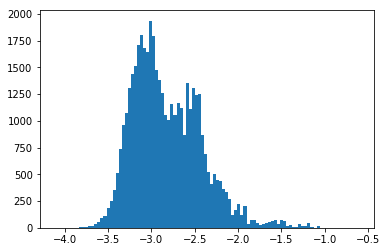

In [40]:
print "is finishedfloor1squarefeet and finishedsquarefeet50 same?"
a=subdf[['finishedfloor1squarefeet','finishedsquarefeet50']].dropna()
print (subdf['finishedfloor1squarefeet'].isnull() == subdf['finishedsquarefeet50'].isnull()).mean()
print  np.mean(a.values[:,0]==a.values[:,1])
print a.max()
print a.min()
b=a.values[:,0]-a.values[:,1]
b=b[b<>0]
plt.hist(abslog10(b),bins=100);

In [28]:
print "is finishedsquarefeet greater than others?"
for col in cols:
    a=subdf[['finishedsquarefeet',col]].dropna()
    print col, len(a), np.round([float(len(a))/len(subdf), np.mean(a.values[:,0]>=a.values[:,1])],3)

is finishedsquarefeet greater than others?
finishedfloor1squarefeet 3039726 [ 0.321  0.969]
finishedsquarefeet 9013231 [ 0.952  1.   ]
finishedsquarefeet8 405164 [ 0.043  0.976]
finishedsquarefeet9 886892 [ 0.094  1.   ]
finishedsquarefeet6 2429791 [ 0.257  0.982]
finishedsquarefeet7 13368 [ 0.001  0.909]
finishedsquarefeet10 1592722 [ 0.168  0.775]
finishedsquarefeet12 5963068 [ 0.63   0.999]
finishedsquarefeet13 64845 [ 0.007  1.   ]
finishedsquarefeet15 981895 [ 0.104  0.683]
unfinishedbasementsqft 288397 [ 0.03   0.992]
finishedsquarefeet11 928910 [ 0.098  0.892]
finishedbasementsqft 520297 [ 0.055  0.996]
finishedsquarefeet50 3039726 [ 0.321  0.968]


How about their difference?
finishedfloor1squarefeet 1773428 0.187402827398


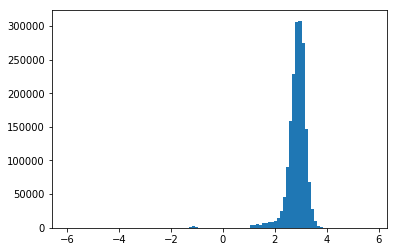

missing
finishedsquarefeet8 53163 0.00561787482378


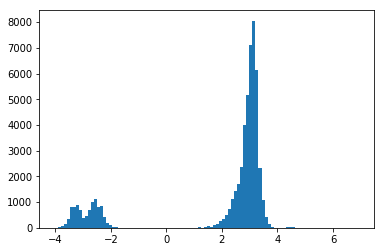

finishedsquarefeet9 398 4.20577126924e-05


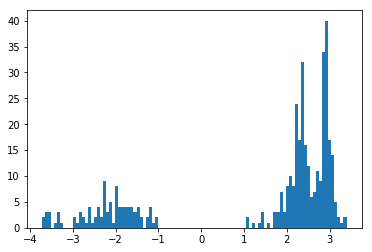

finishedsquarefeet6 1485384 0.156964456055


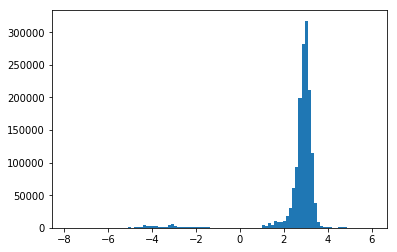

finishedsquarefeet7 13183 0.00139308247845


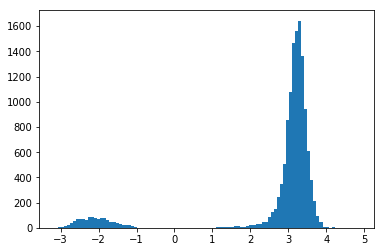

finishedsquarefeet10 391016 0.04131969494


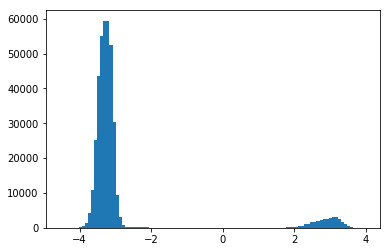

finishedsquarefeet12 11075 0.00117032454288


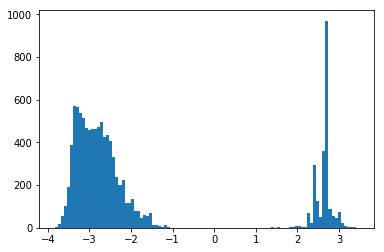

finishedsquarefeet13 64740 0.00684124703443


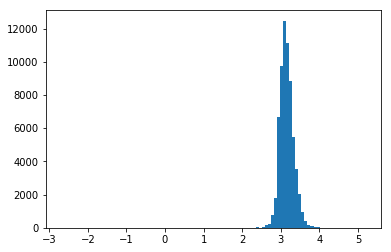

finishedsquarefeet15 407218 0.0430318031336


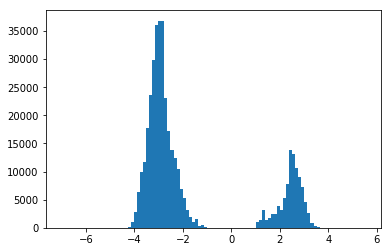

unfinishedbasementsqft 257986 0.0272620629815


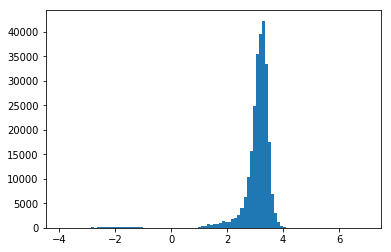

finishedsquarefeet11 602464 0.0636639643706


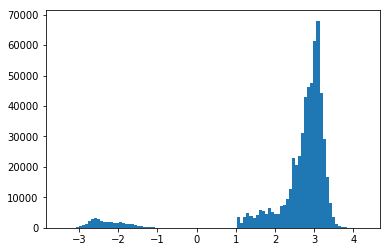

finishedbasementsqft 512602 0.0541680091496


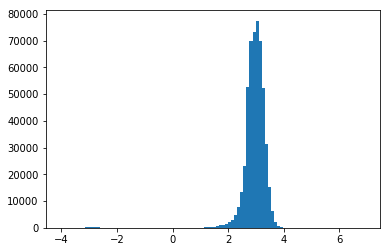

finishedsquarefeet50 1764232 0.186431061755


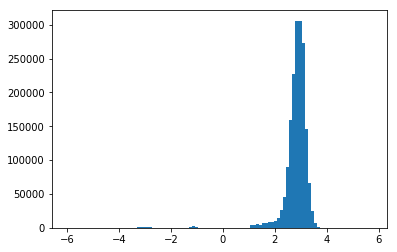

In [104]:
print "How about their difference?"
for col in cols:
    a=subdf[['finishedsquarefeet',col]].dropna()
    b=a.values[:,0]-a.values[:,1]
    b=b[abs(b)>10]
    if (len(b)==0):
        print "missing"
        continue
    print col,len(b), float(len(b))/len(subdf)
    plt.hist(abslog10(b),bins=100);
    plt.show()


# about lot

In [51]:
a=subdf['lotsizeirregularity']

In [52]:
a=a[a<>'nan']

In [59]:
g(a.iloc[3])

25810.0

In [85]:
def g(u):
    if u=="nan":
        return np.nan
    u=u.lower()
    try:
        u=  u.split("x")
        u= [v.strip() for v in u]
        u=[v for v in u if  len(v)>0]
        if len(u)<2: 
            return np.nan        
        u=[float(v) for v in u]
    except:
        print u
        return np.nan
    assert(len(u)==2)
    return u[0]*u[1]


In [86]:
subdf['lotsizeirregularity_sqft']=subdf['lotsizeirregularity'].map(g)

['96', '382 irr']


In [88]:
subdf['depthXrontage_sqft']=subdf['lotsizedepthfeet']*subdf['lotsizefrontagefeet']

In [89]:
cols = [u for u in subdf.columns if 'lot' in u]
cols

['lotsizefrontagefeet',
 'lotsiteappeals',
 'lotsizesquarefeet',
 'lotsizetopographytypeid',
 'lotsizeirregularity',
 'lotsizedepthfeet',
 'lotsizeirregularity_sqft']

In [94]:
cols=[
 'lotsizesquarefeet',
 'lotsizeirregularity_sqft',
 'depthXrontage_sqft']

In [95]:
subdf[cols].isnull().mean().sort_values()

lotsizesquarefeet           0.127516
depthXrontage_sqft          0.694050
lotsizeirregularity_sqft    0.974794
dtype: float64

In [96]:
subdf[cols].isnull().prod(1).mean()

0.125267206491851

In [97]:
pd.concat([subdf[cols].max(),subdf[cols].min()],axis=1)

0    1
lotsizesquarefeet         1.599995e+10  1.0
lotsizeirregularity_sqft  1.600000e+10  0.0
depthXrontage_sqft        1.600000e+10  1.0

In [99]:
print "is lotsizesquarefeet greater than others?"
for col in cols:
    a=subdf[['lotsizesquarefeet',col]].dropna()
    print col, len(a), np.round([float(len(a))/len(subdf), np.mean(a.values[:,0]>=a.values[:,1])],3)

is lotsizesquarefeet greater than others?
lotsizesquarefeet 8256479 [ 0.872  1.   ]
lotsizeirregularity_sqft 238532 [ 0.025  0.963]
depthXrontage_sqft 2873984 [ 0.304  0.724]


How about their difference?
lotsizesquarefeet 0 0.0
missing
lotsizeirregularity_sqft 6378 0.000673980129527


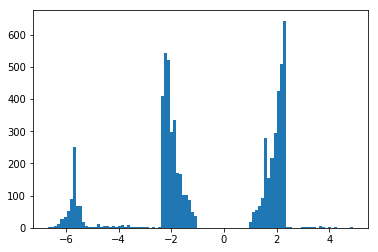

depthXrontage_sqft 1048722 0.110821227563


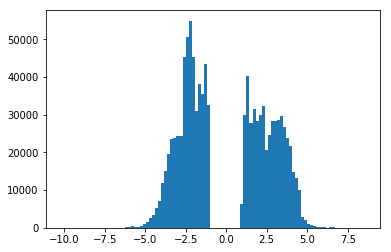

In [102]:
print "How about their difference?"
for col in cols:
    a=subdf[['lotsizesquarefeet',col]].dropna()
    b=a.values[:,0]-a.values[:,1]
    b=b[np.abs(b)>10]
    print col,len(b),float(len(b))/len(subdf)    
    if (len(b)==0):
        print "missing"
        continue
    plt.hist(abslog10(b),bins=100);
    plt.show()


# about yard

In [105]:
cols = [u for u in subdf.columns if 'yard' in u]
cols

['yardbuildingsqft18',
 'yardbuildingsqft12',
 'yardbuildingsqft14',
 'yardbuildingsqft26',
 'yardbuildingsqft20',
 'yardbuildingsqft2',
 'yardbuildingsqft1',
 'yardbuildingsqft7',
 'yardbuildingsqft6',
 'yardbuildingsqft5',
 'yardbuildingsqft4',
 'yardbuildingsqft9',
 'yardbuildingsqft23',
 'yardbuildingsqft27',
 'yardbuildingsqft28',
 'yardbuildingsqft29',
 'yardbuildingsqft31',
 'yardbuildingsqft3',
 'yardbuildingsqft8',
 'yardbuildingsqft22',
 'yardbuildingsqft19',
 'yardbuildingsqft21',
 'yardbuildingsqft13',
 'yardbuildingsqft11',
 'yardbuildingsqft10',
 'yardbuildingsqft17',
 'yardbuildingsqft16',
 'yardbuildingsqft24',
 'yardbuildingsqft25',
 'yardbuildingsqft30']

In [106]:
subdf[cols].isnull().mean().sort_values()

yardbuildingsqft17    0.921771
yardbuildingsqft25    0.958066
yardbuildingsqft31    0.985322
yardbuildingsqft26    0.985364
yardbuildingsqft3     0.988053
yardbuildingsqft21    0.989055
yardbuildingsqft14    0.993663
yardbuildingsqft30    0.997912
yardbuildingsqft9     0.998343
yardbuildingsqft8     0.998362
yardbuildingsqft27    0.998571
yardbuildingsqft7     0.998688
yardbuildingsqft20    0.998733
yardbuildingsqft29    0.999497
yardbuildingsqft18    0.999622
yardbuildingsqft4     0.999654
yardbuildingsqft28    0.999679
yardbuildingsqft2     0.999697
yardbuildingsqft5     0.999723
yardbuildingsqft16    0.999777
yardbuildingsqft24    0.999792
yardbuildingsqft11    0.999793
yardbuildingsqft13    0.999808
yardbuildingsqft19    0.999929
yardbuildingsqft23    0.999940
yardbuildingsqft12    0.999954
yardbuildingsqft22    0.999970
yardbuildingsqft6     0.999993
yardbuildingsqft10    0.999995
yardbuildingsqft1     0.999995
dtype: float64

    17	Patio
    25	Shed
    31	Utility Building
    26	Storage Building
    3	Barn

In [107]:
subdf[cols].isnull().prod(1).mean()

0.8428920404933349

In [108]:
pd.concat([subdf[cols].max(),subdf[cols].min()],axis=1)

0       1
yardbuildingsqft18  2.544000e+03     2.0
yardbuildingsqft12  1.710000e+04    24.0
yardbuildingsqft14  1.970500e+09     1.0
yardbuildingsqft26  1.910490e+09     1.0
yardbuildingsqft20  4.285250e+08     1.0
yardbuildingsqft2   4.900000e+04     1.0
yardbuildingsqft1   2.250000e+04  2400.0
yardbuildingsqft7   2.145330e+06     1.0
yardbuildingsqft6   1.094000e+03     1.0
yardbuildingsqft5   2.881400e+08     1.0
yardbuildingsqft4   6.963600e+08     1.0
yardbuildingsqft9   8.880000e+08     1.0
yardbuildingsqft23  7.104000e+03    36.0
yardbuildingsqft27  8.167500e+08     1.0
yardbuildingsqft28  1.586020e+06     1.0
yardbuildingsqft29  8.081000e+08     1.0
yardbuildingsqft31  9.684000e+08     1.0
yardbuildingsqft3   1.631916e+09     1.0
yardbuildingsqft8   1.119135e+09     1.0
yardbuildingsqft22  6.000000e+03     1.0
yardbuildingsqft19  1.282800e+08    12.0
yardbuildingsqft21  9.824000e+08     1.0
yardbuildingsqft13  1.900000e+04     1.0
yardbuildingsqft11  1.994850e+09     6.0
yardbuildingsqft10  4.740000e+04    60.0
yardbuildingsqft17  9.816000e+08     1.0
yardbuildingsqft16  5.281800e+08    14.0
yardbuildingsqft24  1.800000e+05     1.0
yardbuildingsqft25  1.604720e+09     1.0
yardbuildingsqft30  5.854000e+03     3.0

In [111]:
(~subdf[cols].isnull()).sum(1).value_counts()

0    7976445
1    1231552
2     204356
3      36855
4      10620
5       3359
dtype: int64

In [109]:
subdf['yardsum_sqft']=subdf[cols].sum(1)

In [110]:
subdf['yardsum_sqft'].isnull().mean()

0.84289204049333488

# about garage

In [112]:
cols = [u for u in subdf.columns if 'garage' in u]
cols

['garagedetachedsqft', 'garagetotalsqft', 'garagecarcnt', 'garageattachedsqft']

In [123]:
for col in cols:
    subdf.loc[subdf[col]==0,col]=np.nan

In [124]:
subdf[cols].isnull().mean().sort_values()

garagecarcnt          0.479857
garagetotalsqft       0.651361
garageattachedsqft    0.740767
garagedetachedsqft    0.910594
dtype: float64

In [125]:
subdf[cols].isnull().sum(1).value_counts()

4    4514913
1    3273179
3    1649034
2      26061
dtype: int64

In [129]:
subdf[cols][subdf['garagedetachedsqft']>0].head()

garagedetachedsqft  garagetotalsqft  garagecarcnt  garageattachedsqft
6461               342.0            342.0           1.0                 NaN
6468               576.0            576.0           2.0                 NaN
6470               576.0            576.0           2.0                 NaN
6472               936.0            936.0           8.0                 NaN
6473               768.0            768.0           3.0                 NaN

In [130]:
subdf[cols][subdf['garageattachedsqft']>0].head()

garagedetachedsqft  garagetotalsqft  garagecarcnt  garageattachedsqft
1896                 NaN            508.0           2.0               508.0
1897                 NaN            504.0           2.0               504.0
1898                 NaN            576.0           2.0               576.0
1899                 NaN            478.0           2.0               478.0
1900                 NaN            440.0           2.0               440.0

In [131]:
subdf[cols][(subdf['garageattachedsqft']>0) & (subdf['garagedetachedsqft']>0)].head()

Empty DataFrame
Columns: [garagedetachedsqft, garagetotalsqft, garagecarcnt, garageattachedsqft]
Index: []

In [132]:
pd.concat([subdf[cols].max(),subdf[cols].min()],axis=1)

0    1
garagedetachedsqft   8232.0  1.0
garagetotalsqft     90080.0  1.0
garagecarcnt         2954.0  1.0
garageattachedsqft  90080.0  1.0

In [133]:
(~subdf[cols].isnull()).sum(1).value_counts()

0    4514913
3    3273179
1    1649034
2      26061
dtype: int64

In [137]:
(subdf['garagetotalsqft']-subdf['garageattachedsqft'].fillna(0)-subdf['garagedetachedsqft'].fillna(0)).max()

0.0

In [138]:
(subdf['garagetotalsqft']-subdf['garageattachedsqft'].fillna(0)-subdf['garagedetachedsqft'].fillna(0)).min()

0.0

In [140]:
print "it is safe to use garagetotalsqft. However detached is more cost than attached"

it is safe to use garagetotalsqft. However detached is more cost than attached


# lot, garage, finished, basement, floor1

In [160]:
cols =[u'finishedsquarefeet50','finishedsquarefeet',
       u'yardsum_sqft', 'lotsizesquarefeet','garagetotalsqft']

In [161]:
subdf[cols].isnull().mean().sort_values()

finishedsquarefeet      0.047548
lotsizesquarefeet       0.127516
garagetotalsqft         0.651361
finishedsquarefeet50    0.678784
yardsum_sqft            0.842892
dtype: float64

In [162]:
subdf[cols][subdf['finishedsquarefeet']>0].head()

finishedsquarefeet50  finishedsquarefeet  yardsum_sqft  lotsizesquarefeet  \
0                   NaN              1268.0           NaN                NaN   
1                   NaN              1287.0           NaN                NaN   
2                   NaN               589.0           NaN                NaN   
3                   NaN              2374.0           NaN             1875.0   
4                   NaN               880.0           NaN                NaN   

   garagetotalsqft  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [157]:
((subdf['lotsizesquarefeet']-subdf['finishedsquarefeet50']).dropna()>=0).mean()

0.99473409377707012

In [159]:
((subdf['finishedsquarefeet']-subdf['finishedsquarefeet50']).dropna()>=0).mean()

0.96770136518883609

In [158]:
((subdf['lotsizesquarefeet']-subdf['finishedsquarefeet']).dropna()>=0).mean()

0.96213745615566326

In [163]:
((subdf['lotsizesquarefeet']-subdf['garagetotalsqft']).dropna()>=0).mean()

0.99973826467550608

In [156]:
((subdf['lotsizesquarefeet']-subdf['yardsum_sqft']).dropna()>=0).mean()

0.99773584793350556

In [165]:
((subdf['lotsizesquarefeet']-subdf['yardsum_sqft'].fillna(0)-subdf['finishedsquarefeet50']
  -subdf['garagetotalsqft'].fillna(0)).dropna()>=0).mean()

0.99275754216613565